In [1]:
from lib.envs.gridworld import GridworldEnv

In [22]:
import numpy as np
import itertools
from collections import defaultdict
from __future__ import division
import sklearn
import sklearn.pipeline
from sklearn.preprocessing import LabelBinarizer

In [3]:
env = GridworldEnv()

In [4]:
DISCOUNT_FACTOR = 0.9
nA = env.action_space.n
nS = env.observation_space.n

In [5]:
np.random.seed(123)

In [211]:
def create_random_policy():
    """ random policy that outputs actions probabilites"""
    A = np.random.rand(nS, nA)
    P = A / np.sum(A, axis=1).reshape(-1, 1)
    return P

In [232]:
behaviour_policy = np.ones([nS, nA])/nA # uniform policy

In [233]:
def policy_eval(policy, threshold=0.00001):
    """
    Evaluate a policy given an environment and a full description of the environment's dynamics.
    
    Args:
        policy: [S, A] shaped matrix representing the policy.
        env: OpenAI env. env.P represents the transition probabilities of the environment.
            env.P[s][a] is a (prob, next_state, reward, done) tuple.
        theta: We stop evaluation once our value function change is less than theta for all states.
        discount_factor: lambda discount factor.
    
    Returns:
        Vector of length env.nS representing the value function.
    """
    # Start with a random (all 0) value function
    V = np.zeros(nS)
    while True:
        delta = 0
        # For each state, perform a "full backup"
        for s in range(env.nS):
            v = 0
            # Look at the possible next actions
            for a, action_prob in enumerate(policy[s]):
                # For each action, look at the possible next states...
                for  prob, next_state, reward, done in env.P[s][a]:
                    # Calculate the expected value
                    v += action_prob * prob * (reward + DISCOUNT_FACTOR * V[next_state])
            # How much our value function changed (across any states)
            delta = max(delta, np.abs(v - V[s]))
            V[s] = v
        # Stop evaluating once our value function change is below a threshold
        if delta < threshold:
            break
    # compute state-action value 
    Q = np.zeros([nS, nA])
    for s in range(nS):
        for a in range(nA):
            q = 0
            for prob, next_state, reward, done in env.P[s][a]:
                q += prob* (reward + DISCOUNT_FACTOR * V[next_state])
            Q[s, a] = q
    return Q, V

In [234]:
target_policy = create_random_policy()
trueQ, trueV = policy_eval(target_policy)

In [235]:
# sanity check
np.testing.assert_array_almost_equal(trueV, np.sum(target_policy * trueQ, axis=1), decimal=2)

In [265]:
def tree_backup(functionApprox,theta,
                target_policy, behaviour_policy, lambda_param = 0.6, alpha = 0.5, num_episodes = 1000):
    trueQ, _ = policy_eval(target_policy)
    errors = []
    for episode in range(num_episodes):
        state = env.reset()

        #initialising eligibility traces
        e = np.zeros(shape=theta.shape)
        
        for t in itertools.count():
            if state in END_STATES:
                break
                
            action_probs = behaviour_policy[state]
            action = np.random.choice(np.arange(nA), p=action_probs)

            next_state, reward, done, _ = env.step(action)
            
            features_s_a = functionApprox.featurize_s_a(state, action)
            q_s_a = functionApprox.value_s_a(state, action, theta)

            q_next_s = functionApprox.value_s(next_state, theta) 
            
            pi_next_s = target_policy[next_state]
            V = np.sum (pi_next_s * q_next_s)

            td_target = reward + DISCOUNT_FACTOR * V

            delta = td_target - q_s_a


            pi_s_a = target_policy[state, action]


            e *= DISCOUNT_FACTOR * lambda_param * pi_s_a
            e += features_s_a

            theta += alpha * delta * e

            if done:
                break
            
            state = next_state
        #if (episode + 1) % 3000 == 0: 
        #    alpha = alpha/10.0
        q = np.zeros([nS, nA])
        for s in range(nS):
            q_s = functionApprox.value_s(s, theta)
            q[s, :] = q_s.reshape(-1, )
        error = np.sqrt(np.mean(np.power(trueQ-q, 2)))
        errors.append(error)
        print "episode %d, error %f" % (episode, error) 
    return errors

In [266]:
def gradient_tree_backup(functionApprox, theta,
                         target_policy, behaviour_policy, lambda_param = 0.6, alpha = 0.5, num_episodes = 1000):
    errors = []
    omega = np.zeros(shape=theta.shape)
    trueQ, _ = policy_eval(target_policy)
    for episode in range(num_episodes):
        state = env.reset()

        #initialising eligibility traces
        e = np.zeros(shape=theta.shape)
        
        for t in itertools.count():
            if state in END_STATES:
                break
            old_omega = omega
            old_theta = theta
            action_probs = behaviour_policy[state]
            action = np.random.choice(np.arange(nA), p=action_probs)

            next_state, reward, done, _ = env.step(action)
            
            features_s_a = functionApprox.featurize_s_a(state, action)
            q_s_a = functionApprox.value_s_a(state, action, old_theta)

            q_next_s = functionApprox.value_s(next_state, old_theta) 
            
            pi_next_s = target_policy[next_state]
            V = np.sum (pi_next_s * q_next_s)

            td_target = reward + DISCOUNT_FACTOR * V

            delta = td_target - q_s_a


            pi_s_a = target_policy[state, action]


            e *= DISCOUNT_FACTOR * lambda_param * pi_s_a
            e += features_s_a
            
            omega = old_omega + \
            alpha * (delta * e- 
                     functionApprox.value_s_a(state, action, old_omega) * features_s_a)
            
            theta = old_theta - \
            alpha * np.sum (old_omega * e) * \
            (DISCOUNT_FACTOR * np.sum([target_policy[next_state, a] 
                                       * functionApprox.featurize_s_a(next_state, a) for a in np.arange(nA)], axis=0)
             - features_s_a)
            
            

            if done:
                break
            
            state = next_state
        #if (episode + 1) % 3000 == 0: 
        #    alpha = alpha/10.0
        q = np.zeros([nS, nA])
        for s in range(nS):
            q_s = functionApprox.value_s(s, theta)
            q[s, :] = q_s.reshape(-1, )
        error = np.sqrt(np.mean(np.power(trueQ-q, 2)))
        errors.append(error)
        print "episode %d, error %f" % (episode, error) 
    return errors

In [267]:
def extra_gradient_tree_backup(functionApprox, theta,
                         target_policy, behaviour_policy, lambda_param = 0.6, alpha = 0.5, num_episodes = 1000):
    errors = []
    omega = np.zeros(shape = theta.shape)
    trueQ, _ = policy_eval(target_policy)
    for episode in range(num_episodes):
        state = env.reset()

        #initialising eligibility traces
        e = np.zeros(shape=theta.shape)
        
        for t in itertools.count():
            if state in END_STATES:
                break
            old_omega = omega
            old_theta = theta
            action_probs = behaviour_policy[state]
            action = np.random.choice(np.arange(nA), p=action_probs)

            next_state, reward, done, _ = env.step(action)
            
            features_s_a = functionApprox.featurize_s_a(state, action)
            q_s_a = functionApprox.value_s_a(state, action, old_theta)

            q_next_s = functionApprox.value_s(next_state, old_theta) 
            
            pi_next_s = target_policy[next_state]
            V = np.sum (pi_next_s * q_next_s)

            td_target = reward + DISCOUNT_FACTOR * V

            delta = td_target - q_s_a


            pi_s_a = target_policy[state, action]


            e *= DISCOUNT_FACTOR * lambda_param * pi_s_a
            e += features_s_a
            
            omega_m = old_omega + \
            alpha * (delta * e- 
                     functionApprox.value_s_a(state, action, old_omega) * features_s_a)
            
            theta_m = old_theta - \
            alpha * np.sum (old_omega * e) * \
            (DISCOUNT_FACTOR * np.sum([target_policy[next_state, a] 
                                       * functionApprox.featurize_s_a(next_state, a) for a in np.arange(nA)], axis=0)
             - features_s_a)
            
            
            q_s_a_m = functionApprox.value_s_a(state, action, theta_m)
            q_next_s_m = functionApprox.value_s(next_state, theta_m)
            V_m = np.sum (pi_next_s * q_next_s_m)
            td_target_m = reward + DISCOUNT_FACTOR * V_m
            delta_m = td_target_m - q_s_a_m
            
            omega = old_omega + \
            alpha * (delta_m * e- 
                     functionApprox.value_s_a(state, action, omega_m) * features_s_a)
            
            theta = old_theta - \
            alpha * np.sum (omega_m * e) * \
            (DISCOUNT_FACTOR * np.sum([target_policy[next_state, a] 
                                       * functionApprox.featurize_s_a(next_state, a) for a in np.arange(nA)], axis=0)
             - features_s_a)
            
            

            if done:
                break
            
            state = next_state
        #if (episode + 1) % 3000 == 0: 
        #    alpha = alpha/10.0
        q = np.zeros([nS, nA])
        for s in range(nS):
            q_s = functionApprox.value_s(s, theta)
            q[s, :] = q_s.reshape(-1, )
        error = np.sqrt(np.mean(np.power(trueQ-q, 2)))
        errors.append(error)
        print "episode %d, error %f" % (episode, error) 
    return errors

# Tabular features

In [298]:
# Tabular features
END_STATES = [0, nS-1]
theta = np.zeros(nS*nA)
class FunctionApprox():
    def __init__(self):
        labels = [ '+'.join([str(s), str(a)]) for s in np.arange(nS) for a in np.arange(nA)]
        self.lb = LabelBinarizer()
        self.lb.fit(labels)
        
    def value_s_a(self, state, action, theta):
        if state in END_STATES:
            return 0
        else:
            features_s_a = self.featurize_s_a(state, action)
            q_s_a = np.dot(theta.T, features_s_a)
            return float(q_s_a)

    def value_s(self, state, theta):
        if state in END_STATES:
            return np.zeros(nA)
        else:
            q_s = [np.dot(theta.T, self.featurize_s_a(state, action)) for action in np.arange(nA)]
            return np.array(q_s)
    def featurize_s_a(self, s, a):
        return self.lb.transform(['+'.join([str(s), str(a)]) ]).reshape(-1,)

In [272]:
functionApprox = FunctionApprox()
behaviour_policy = np.ones([nS, nA])/nA # uniform policy
target_policy = create_random_policy()
theta = np.zeros(nS*nA)

In [299]:
functionApprox = FunctionApprox()
theta = np.zeros(nS*nA)
TB_errors0 = tree_backup(functionApprox, theta,
                        target_policy, behaviour_policy, lambda_param = 0.9, alpha = 0.5, num_episodes=3000)

episode 0, error 5.671874
episode 1, error 5.614129
episode 2, error 5.497853
episode 3, error 5.496787
episode 4, error 5.143285
episode 5, error 5.059632
episode 6, error 4.979917
episode 7, error 4.744959
episode 8, error 4.605011
episode 9, error 4.605011
episode 10, error 4.457900
episode 11, error 4.380188
episode 12, error 4.295163
episode 13, error 4.024749
episode 14, error 4.005285
episode 15, error 3.773194
episode 16, error 3.773170
episode 17, error 3.773170
episode 18, error 3.773164
episode 19, error 3.768416
episode 20, error 3.629248
episode 21, error 3.474800
episode 22, error 3.472365
episode 23, error 3.471259
episode 24, error 3.104304
episode 25, error 3.083094
episode 26, error 3.011202
episode 27, error 3.009620
episode 28, error 3.009620
episode 29, error 3.009620
episode 30, error 2.952666
episode 31, error 2.877279
episode 32, error 2.877279
episode 33, error 2.715879
episode 34, error 2.715879
episode 35, error 2.708585
episode 36, error 2.708583
episode 37,

In [300]:
theta = np.zeros(nS*nA)
GTB_errors0 = gradient_tree_backup(functionApprox, theta,
                                  target_policy, behaviour_policy, lambda_param = 0.9, alpha = 0.5, num_episodes=3000)

episode 0, error 6.002807
episode 1, error 6.002807
episode 2, error 6.002039
episode 3, error 5.998245
episode 4, error 5.996294
episode 5, error 5.995089
episode 6, error 5.994061
episode 7, error 5.986650
episode 8, error 5.980847
episode 9, error 5.980338
episode 10, error 5.919408
episode 11, error 5.893100
episode 12, error 5.874073
episode 13, error 5.871369
episode 14, error 5.857422
episode 15, error 5.840336
episode 16, error 5.834052
episode 17, error 5.830789
episode 18, error 5.815682
episode 19, error 5.800239
episode 20, error 5.775079
episode 21, error 5.772005
episode 22, error 5.766101
episode 23, error 5.647182
episode 24, error 5.622289
episode 25, error 5.605123
episode 26, error 5.592860
episode 27, error 5.594314
episode 28, error 5.588886
episode 29, error 5.563950
episode 30, error 5.563950
episode 31, error 5.547076
episode 32, error 5.506184
episode 33, error 5.506184
episode 34, error 5.506184
episode 35, error 5.501785
episode 36, error 5.467857
episode 37,

In [254]:
theta = np.zeros(nS*nA)
EGTB_errors0 = extra_gradient_tree_backup(functionApprox, theta,
                                   target_policy, behaviour_policy, lambda_param = 0.9, alpha = 0.0005, num_episodes=5000)

episode 0, error 6.267232
episode 1, error 6.253472
episode 2, error 6.253470
episode 3, error 6.240683
episode 4, error 5.988505
episode 5, error 5.951323
episode 6, error 5.951323
episode 7, error 5.944898
episode 8, error 5.923624
episode 9, error 5.917740
episode 10, error 5.907848
episode 11, error 5.890461
episode 12, error 5.782210
episode 13, error 5.779347
episode 14, error 5.779207
episode 15, error 5.773560
episode 16, error 5.750666
episode 17, error 5.709832
episode 18, error 5.635900
episode 19, error 5.634579
episode 20, error 5.630618
episode 21, error 5.609833
episode 22, error 5.609833
episode 23, error 5.609833
episode 24, error 5.589786
episode 25, error 5.588560
episode 26, error 5.535358
episode 27, error 5.533724
episode 28, error 5.533383
episode 29, error 5.525785
episode 30, error 5.434086
episode 31, error 5.434086
episode 32, error 5.434086
episode 33, error 5.423110
episode 34, error 5.399878
episode 35, error 5.382470
episode 36, error 5.357351
episode 37,

In [281]:
import  matplotlib.pylab as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Tmp/lisa/os_v5/anaconda/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['plt']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [285]:
len(TB_errors)

3000

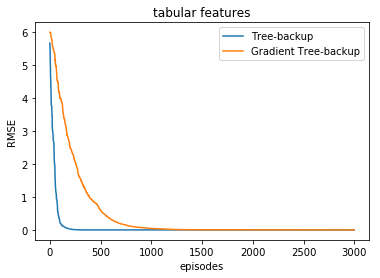

In [301]:
plt.plot(np.arange(len(TB_errors0)), TB_errors0, label='Tree-backup')
plt.plot(np.arange(len(TB_errors0)), GTB_errors0[: 3000], label='Gradient Tree-backup')
plt.xlabel('episodes')
plt.ylabel('RMSE')
plt.title('tabular features')
plt.legend()
plt.savefig('tabular_features.png')
plt.show()

# coordinates features

In [302]:
# coordinates features
END_STATES = [0, nS-1]
class FunctionApprox():
    def value_s_a(self, state, action, theta):
        if state in END_STATES:
            return 0
        else:
            features_s_a = self.featurize_s_a(state, action)
            q_s_a = np.dot(theta, features_s_a)
            return float(q_s_a)

    def value_s(self, state, theta):
        if state in END_STATES:
            return np.zeros(nA)
        else:
            q_s = [np.dot(theta, self.featurize_s_a(state, action)) for action in np.arange(nA)]
            return np.array(q_s)
    def featurize_s_a(self, s, a):
        x = s // 4
        y = s % 4
        if a == 0:
            return np.array([a, y, 0, -1])
        if a == 1:
            return np.array([a, y, 1, 0])
        if a == 2:
            return np.array([a, y, 0, 1])
        if a == 3:
            return np.array([a, y, -1, 0])

In [311]:
behaviour_policy = np.ones([nS, nA])/nA # uniform policy
target_policy = create_random_policy()

In [312]:
functionApprox = FunctionApprox()
theta = np.zeros(4)
TB_errors = tree_backup(functionApprox, theta,
                        target_policy, behaviour_policy, lambda_param = 0.9, alpha = 0.0004, num_episodes=6000)

episode 0, error 7.248322
episode 1, error 7.240100
episode 2, error 7.213710
episode 3, error 7.207312
episode 4, error 7.197894
episode 5, error 7.195453
episode 6, error 7.193481
episode 7, error 7.184357
episode 8, error 7.154455
episode 9, error 7.154455
episode 10, error 7.038545
episode 11, error 7.036920
episode 12, error 7.031467
episode 13, error 7.017608
episode 14, error 7.008039
episode 15, error 7.008039
episode 16, error 7.008039
episode 17, error 6.983982
episode 18, error 6.976298
episode 19, error 6.933893
episode 20, error 6.919467
episode 21, error 6.807049
episode 22, error 6.764774
episode 23, error 6.731574
episode 24, error 6.715355
episode 25, error 6.663615
episode 26, error 6.639102
episode 27, error 6.639102
episode 28, error 6.632888
episode 29, error 6.607251
episode 30, error 6.598910
episode 31, error 6.594062
episode 32, error 6.573127
episode 33, error 6.565531
episode 34, error 6.525378
episode 35, error 6.517780
episode 36, error 6.497291
episode 37,

In [313]:
theta = np.zeros(4)
GTB_errors = gradient_tree_backup(functionApprox, theta,
                                  target_policy, behaviour_policy, lambda_param = 0.9, alpha = 0.0004, num_episodes=6000)

episode 0, error 7.251013
episode 1, error 7.250477
episode 2, error 7.250477
episode 3, error 7.250371
episode 4, error 7.250252
episode 5, error 7.250428
episode 6, error 7.250425
episode 7, error 7.250425
episode 8, error 7.250425
episode 9, error 7.248916
episode 10, error 7.248474
episode 11, error 7.248474
episode 12, error 7.248472
episode 13, error 7.248322
episode 14, error 7.248276
episode 15, error 7.246686
episode 16, error 7.247019
episode 17, error 7.247019
episode 18, error 7.246429
episode 19, error 7.245917
episode 20, error 7.245984
episode 21, error 7.244019
episode 22, error 7.243126
episode 23, error 7.240160
episode 24, error 7.234986
episode 25, error 7.232489
episode 26, error 7.229429
episode 27, error 7.229766
episode 28, error 7.223047
episode 29, error 7.211027
episode 30, error 7.208863
episode 31, error 7.205714
episode 32, error 7.203419
episode 33, error 7.200313
episode 34, error 7.199355
episode 35, error 7.199352
episode 36, error 7.197900
episode 37,

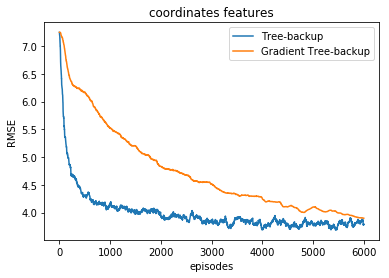

In [314]:
plt.plot(np.arange(len(TB_errors)), TB_errors, label='Tree-backup')
plt.plot(np.arange(len(TB_errors)), GTB_errors, label='Gradient Tree-backup')
plt.xlabel('episodes')
plt.ylabel('RMSE')
plt.title('coordinates features')
plt.legend()
plt.savefig('coordinates_features.png')
plt.show()